# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 5

**Author 1 (sciper):** Camillo Nicolò De Sabbata (335004)  
**Author 2 (sciper):** Gianluca Radi (334736)   
**Author 3 (sciper):** Alessandro Dalbesio (352298) 

**Release date:** 19.04.2023  
**Due date:** 05.05.2023 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

## 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

In this lab, we will use PyTorch. If you are not familiar with this library, [here](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html) is a quick tutorial of the basics.

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1 - Out-of-Distribution detection in colorectal cancer histology (12 points)

Colorectal cancer is one of the most widespread cancers for men and women. Diagnosis complemented with prognostic and predictive biomarker information is essential for patient monitoring and applying personalized treatments. A critical marker is the tumor/stroma ratio in unhealthy tissues sampled from the colon. The higher the ratio, the more invasive the cancer is. The degree of invasion is tightly linked to patient survial probability.

To measure the ratio, a pathologist needs to analyze the unhealthy tissue under a microscope and estimate it from a look. As the number of samples to analyze is huge and estimations are only sometimes precise, automatic recognition of the different tissue types in histological images has become essential. Such an automatic process requires the development of a multi-class classifier to identify the numerous tissues. As shown below, they are usually 8 tissue types to categorize: TUMOR, STROMA, LYMPHO (lymphocytes), MUCOSA, COMPLEX (complex stroma), DEBRIS, ADIPOSE and EMPTY (background).

<br />
<br />
<figure>
    <img src="../data/lab-03-data/part1/kather16.svg" width="1100">
    <center>
    <figcaption>Fig1: Collection of tissue types in colorectal cancer histology (Kather-16)</figcaption>
    </center>
</figure>
<br />
<br />


Up to this day, state-of-the-art methods use deep-learning-based supervised learning methods. A downfall of such an approach is the necessity to access a well-annotated training dataset. In histology, annotating data is difficult. It is time-consuming and requires the expertise of pathologists. Moreover, the annotator must label every tissue type while only two (TUMOR and STROMA) are interesting. 


Consequently, we propose another approach. In order to make the annotation task less tedious, we ask the annotator to label only the tissues of interest and dump the others. Then, we must train a binary classifier to automatically recognize these tissues at test time. In this part, you will implement the proposed approach.

### 1.1 Binary classifier with Mahalanobis distance (3 points)

Based on the abovementioned process, your task is to build a model that recognizes TUMOR (Label 0) and STROMA (Label 1) tissue types. Your model will be supervised by a training dataset containing TUMOR and STROMA annotations; note that all other tissues have been dropped.
We will not ask you to train a deep-learning-based binary classifier from scratch. Instead, we provide excellent features (descriptors) of the images we extracted from a visual foundation model. (Note: As the nature of the foundation model is not part of this lecture, feel free to ask TAs if you are curious).

Run the cell below to extract the provided train and test dataset. Each image is represented by a 768-d feature vector extracted from a visual foundation model. The train and test datasets contain feature vectors of 878 and 186 images respectively.

In [3]:
import torch 

# Label mapping
label_to_classname = {0 : "TUMOR", 1 : "STROMA"}

# Train features and labels
train_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_features.pth"))
train_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_labels.pth"))

# Test features and labels
test_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_features.pth"))
test_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_labels.pth"))

**Task 1 (2.5 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using minimum Mahalanobis distance.

*Note:* You are not allowed to use any prebuilt Mahalanobis distance function. Additionally, ```torch.cov``` is not defined to compute the covariance matrix. You can use ```sklearn.covariance.LedoitWolf``` instead.

In [4]:
from sklearn.covariance import LedoitWolf

# Get the values for the two classes
values_class_0 = train_features[train_labels == 0]
values_class_1 = train_features[train_labels == 1]

# Compute the mean of the values of the two classes
mean_class_0 = values_class_0.mean(dim=0)
mean_class_1 = values_class_1.mean(dim=0)

# Compute the covariance matrix for the two classes
lw0 = LedoitWolf()
lw0.fit(values_class_0)
cov0 = torch.inverse(torch.tensor(lw0.covariance_))

lw1 = LedoitWolf()
lw1.fit(values_class_1)
cov1 = torch.inverse(torch.tensor(lw1.covariance_))

# Assign a label to the test data
identified_test_features = torch.zeros(test_features.shape[0])
for i in range(test_features.shape[0]):

    # Compute the distance to the mean of the two classes
    distance_0 = torch.dot(test_features[i] - mean_class_0, torch.matmul(cov0, test_features[i] - mean_class_0))
    distance_1 = torch.dot(test_features[i] - mean_class_1, torch.matmul(cov1, test_features[i] - mean_class_1))

    # Assign the label of the closest class (the most probable class is the one that minimizes the Mahalanobis distance)
    if distance_1 > distance_0:
        identified_test_features[i] = 0
    else:
        identified_test_features[i] = 1

**Task 2 (0.5 points)** Compute the accuracy of your predictions with the test labels (```test_labels```).

In [5]:
wrongAssignments = 0

for i in range(test_features.shape[0]):
    if identified_test_features[i] != test_labels[i]:
        wrongAssignments += 1

print("Wrong assignments: ", wrongAssignments)
print("Correct assignments: ", len(test_features) - wrongAssignments)
print("Accuracy: ", (len(test_features) - wrongAssignments)*100 / len(test_features), " %")

Wrong assignments:  4
Correct assignments:  182
Accuracy:  97.84946236559139  %


### 1.2 Out-of-Distribution detection with Mahalanobis distance (3 points)

You will note that the test you run above is not really realistic. Like the training set, it contains only the TUMOR and STROMA tissue types. Nevertheless, at test time, the other tissues (Label -1) are also present and cannot be filtered by hand. Moreover, they cannot be recognized by the model as they are out of the training distribution (It is the consequence of the laziness of the annotators ;)). For this reason, it is essential to filter them out. This task is called Out-of-Distribution (OoD) detection. 

A simple way to do OoD detection is to compute for every test example an OoD-ness score which should be low for In-Distribution (ID) examples and high for OoDs. Then we define a threshold from which every example with an OoD-ness lying above is discarded, and those lying below are forwarded to the model for prediction. An example of OoD-ness score is the minimum Mahalanobis distance.

Run the cell below to load a new test set containing OoD examples. It has 186 ID and 558 OoD examples.

In [6]:
label_to_classname_w_ood = {0 : "TUMOR", 1 : "STROMA", -1 : "OoD"}

# Test features and labels with OoD tissues
test_features_w_ood = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test2_features.pth"))
test_labels_w_ood = torch.load(os.path.join(data_base_path, data_folder,"part1/k16_test2_labels.pth"))

**Task 1 (0.5 point)** Why do you think the minimum Mahalanobis distance is a good OoD-ness score?

**Answer:** The minimum Mahalanobis distance might be a good OoD-ness score because when it computes the distance to the mean of the class it keeps also into account the distribution of the data in the space. This might give better results than, for example, the euclidean distance which only computes the distance without considering the distribution of the data.

**Task 2 (0.5 point)** Compute the minimum Mahalanobis distance for every test examples in ```test_features_w_ood``` with respect to the training features (```train_features```).

In [7]:
### Task 2
min_distance_class_0 = []
min_distance_class_1 = []
min_distance_OoD = []

for i in range(test_features_w_ood.shape[0]):
    distance_0 = torch.dot(test_features_w_ood[i] - mean_class_0, torch.matmul(cov0, test_features_w_ood[i] - mean_class_0))
    distance_1 = torch.dot(test_features_w_ood[i] - mean_class_1, torch.matmul(cov1, test_features_w_ood[i] - mean_class_1))

    if test_labels_w_ood[i] == 0:
        min_distance_class_0.append(min(distance_0, distance_1))
    elif test_labels_w_ood[i] == 1:
        min_distance_class_1.append(min(distance_0, distance_1))
    elif test_labels_w_ood[i] == -1:
        min_distance_OoD.append(min(distance_0, distance_1))


**Task 3 (0.5 point)** Plot a histogram to show the difference between the Mahalanobis distance of TUMOR, STROMA and OoD tissue types and comment on what you observe.

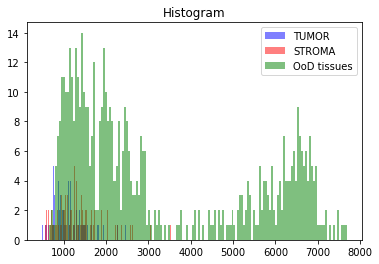

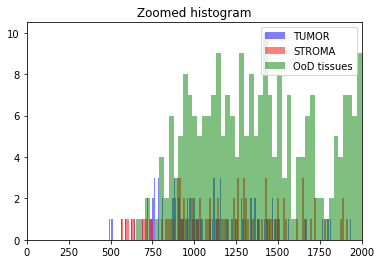

In [8]:
# Plot
import matplotlib.pyplot as plt
import numpy as np

plt.hist(min_distance_class_0, bins=150, color='blue', alpha=0.5, label='TUMOR')
plt.hist(min_distance_class_1, bins=150, color='red', alpha=0.5, label='STROMA')
plt.hist(min_distance_OoD, bins=150, color='green', alpha=0.5, label='OoD tissues')
plt.legend(loc='upper right')
plt.title("Histogram")
plt.show()

# Zoom the histogram for x < 2000
plt.hist(min_distance_class_0, bins=250, color='blue', alpha=0.5, label='TUMOR')
plt.hist(min_distance_class_1, bins=250, color='red', alpha=0.5, label='STROMA')
plt.hist(min_distance_OoD, bins=250, color='green', alpha=0.5, label='OoD tissues')
plt.legend(loc='upper right')
plt.xlim(0, 2000)
plt.title("Zoomed histogram")
plt.show()

**Observations** 
From the results obtained we can see that the elements in tumor and stroma class, as expected, have a low Mahalanobis distance but also lots of OoD tissues have a low distance. This is a problem since it makes it very hard to find a threshold value such that most of the elements of interest are below that threshold and only few OoD are below it.

**Task 4 (1 point)** Find a threshold on the Mahalanobis distance such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out?

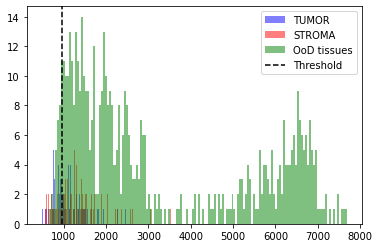

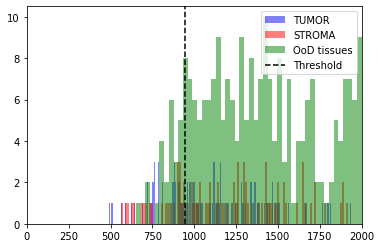

╒═════════════╤═════════════════════╤════════════════════════════════════════════════════╤═════════════════════════════════════════╤═════════════════════════════════════════════════════╤═════════════════════════════════╕
│ Class       │   Number of samples │   Number of samples below threshold (kept samples) │   Percentage of samples below threshold │   Number of samples above samples (removed samples) │   Percentage of removed samples │
╞═════════════╪═════════════════════╪════════════════════════════════════════════════════╪═════════════════════════════════════════╪═════════════════════════════════════════════════════╪═════════════════════════════════╡
│ Tumor       │                  93 │                                                 36 │                                   38.71 │                                                  57 │                           61.29 │
├─────────────┼─────────────────────┼────────────────────────────────────────────────────┼──────────────────────────

In [9]:
from tabulate import tabulate

# Compute the distance such as 95% of min_distance_OoD are above
threshold = np.percentile(min_distance_OoD, 5)

plt.hist(min_distance_class_0, bins=150, color='blue', alpha=0.5, label='TUMOR')
plt.hist(min_distance_class_1, bins=150, color='red', alpha=0.5, label='STROMA')
plt.hist(min_distance_OoD, bins=150, color='green', alpha=0.5, label='OoD tissues')
plt.axvline(x=threshold, color='black', linestyle='--', label='Threshold')
plt.legend(loc='upper right')
plt.show()

# Plot the histogram with the threshold
plt.hist(min_distance_class_0, bins=250, color='blue', alpha=0.5, label='TUMOR')
plt.hist(min_distance_class_1, bins=250, color='red', alpha=0.5, label='STROMA')
plt.hist(min_distance_OoD, bins=250, color='green', alpha=0.5, label='OoD tissues')
plt.axvline(x=threshold, color='black', linestyle='--', label='Threshold')
plt.legend(loc='upper right')
plt.xlim(0, 2000)
plt.show()

# Print thesholding information
headers = ["Class", "Number of samples", "Number of samples below threshold (kept samples)", "Percentage of samples below threshold", "Number of samples above samples (removed samples)", "Percentage of removed samples"]
info = [[
    'Tumor', len(min_distance_class_0), len([x for x in min_distance_class_0 if x <= threshold]), round(len([x for x in min_distance_class_0 if x <= threshold]) / len(min_distance_class_0) * 100,2), len([x for x in min_distance_class_0 if x > threshold]), round(len([x for x in min_distance_class_0 if x > threshold]) / len(min_distance_class_0) * 100, 2)
], [
    'Stroma', len(min_distance_class_1), len([x for x in min_distance_class_1 if x < threshold]), round(len([x for x in min_distance_class_1 if x <= threshold]) / len(min_distance_class_1) * 100,2), len([x for x in min_distance_class_1 if x > threshold]), round(len([x for x in min_distance_class_1 if x > threshold]) / len(min_distance_class_1) * 100, 2)
], [
    'OoD tissues', len(min_distance_OoD), len([x for x in min_distance_OoD if x <= threshold]), round(len([x for x in min_distance_OoD if x <= threshold]) / len(min_distance_OoD) * 100, 2), len([x for x in min_distance_OoD if x > threshold]), round(len([x for x in min_distance_OoD if x > threshold]) / len(min_distance_OoD) * 100,2)
]]
print(tabulate(info, headers=headers, tablefmt='fancy_grid'))

**Task 5 (0.5 point)** Assign prediction -1 to filtered out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```). Is it satisfactory?

In [10]:
### Task 5

predicted_labels = []
for i in range(test_features_w_ood.shape[0]):
    distance_0 = torch.dot(test_features_w_ood[i] - mean_class_0, torch.matmul(cov0, test_features_w_ood[i] - mean_class_0))
    distance_1 = torch.dot(test_features_w_ood[i] - mean_class_1, torch.matmul(cov1, test_features_w_ood[i] - mean_class_1))

    if min(distance_0, distance_1) > threshold:
        predicted_labels.append(-1)
    else:
        if distance_0 < distance_1:
            predicted_labels.append(0)
        else:
            predicted_labels.append(1)

# Compute the accuracy
correct_total = total_elements = 0
correct_class_0 = total_elements_class_0 = 0
correct_class_1 = total_elements_class_1 = 0
correct_OoD = total_elements_OoD = 0

for i in range(len(predicted_labels)):
    total_elements += 1

    correct_result = predicted_labels[i] == test_labels_w_ood[i]
    correct_total += correct_result
    if predicted_labels[i] == -1:
        total_elements_OoD += 1
        correct_OoD += correct_result
    elif predicted_labels[i] == 0:
        total_elements_class_0 += 1
        correct_class_0 += correct_result
    else:
        total_elements_class_1 += 1
        correct_class_1 += correct_result

def accuracy(correct, total):
    return correct / total * 100

headers = ["Class", "Classified correctly", "Classify incorrectly", "Total Number Of Elements","Accuracy"]
info = [[
    "General", correct_total, total_elements - correct_total, total_elements, round(accuracy(correct_total, total_elements), 2)
], [
    "Tumor", correct_class_0, total_elements_class_0 - correct_class_0, total_elements_class_0, round(accuracy(correct_class_0, total_elements_class_0), 2)
], [
    "Stroma", correct_class_1, total_elements_class_1 - correct_class_1, total_elements_class_1, round(accuracy(correct_class_1, total_elements_class_1), 2)
], [
    "OoD", correct_OoD, total_elements_OoD - correct_OoD, total_elements_OoD, round(accuracy(correct_OoD, total_elements_OoD), 2)
]]
print(tabulate(info, headers=headers, tablefmt='fancy_grid'))  

╒═════════╤════════════════════════╤════════════════════════╤════════════════════════════╤════════════╕
│ Class   │   Classified correctly │   Classify incorrectly │   Total Number Of Elements │   Accuracy │
╞═════════╪════════════════════════╪════════════════════════╪════════════════════════════╪════════════╡
│ General │                    590 │                    154 │                        744 │      79.3  │
├─────────┼────────────────────────┼────────────────────────┼────────────────────────────┼────────────┤
│ Tumor   │                     36 │                     27 │                         63 │      57.14 │
├─────────┼────────────────────────┼────────────────────────┼────────────────────────────┼────────────┤
│ Stroma  │                     24 │                      1 │                         25 │      96    │
├─────────┼────────────────────────┼────────────────────────┼────────────────────────────┼────────────┤
│ OoD     │                    530 │                    126 │   

**Remarks**: In this case the class-wise accuracy is pretty good for the class stroma (since 96% of the elements are classified correctly) while is bad for the class tumor (half of the prediction is wrong).

### 1.3 Out-of-distribution detection with k-NN classifier (6 points)

The visual foundation models are known to be very good k-NN classifiers. It motivates us to implement a k-NN classifier to recognize TUMOR and STROMA. Moreover, k-NN distance is a good OoD-ness score and suits our task.

**Task 1 (2 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using a k-NN classifier. Then report the accuracy of your predictions with the test labels (```test_labels```).

*Note:* The choice of `k` is up to you.

In [11]:
from sklearn.neighbors import KNeighborsClassifier
k = 2 # Choosen based on experiments done in the following tasks

# Train the model
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_features, train_labels)

# Predict the labels
predicted_labels = knn.predict(test_features)

# Compute accuracy
correct = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] == test_labels[i]:
        correct += 1
print("Accuracy with k = ", k, ": ", round(correct / len(predicted_labels) * 100, 4), "%")

Accuracy with k =  2 :  100.0 %


/Users/camillonicolodesabbata/opt/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


**Task 2 (2 points)** Perform OoD detection on the test features (```test_features_w_ood```) using a k-NN distance based OoD-ness score. Find a threshold on your OoD-ness score such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out? Finally, assign prediction -1 to filter out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```).

*Note:* The OoD-ness is based on the distance to the k-nearest neighbors. The formulation is up to you. You have to justify your choice.

**Choice** We will use the average distance between the k-neighbords as OoD-score: the elements with an high average distance between the k-neighbords are most probable OoD than elements of some class.

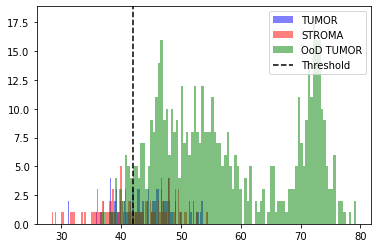

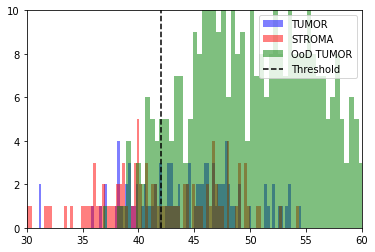

╒═══════════╤═════════════════════╤═════════════════════════════════════╤═════════════════════════════════════════╤═════════════════════════════╤═════════════════════════════════╕
│ Class     │   Number of samples │   Number of samples below threshold │   Percentage of samples below threshold │   Number of removed samples │   Percentage of removed samples │
╞═══════════╪═════════════════════╪═════════════════════════════════════╪═════════════════════════════════════════╪═════════════════════════════╪═════════════════════════════════╡
│ Tumor     │                  93 │                                  32 │                                   34.41 │                          61 │                           65.59 │
├───────────┼─────────────────────┼─────────────────────────────────────┼─────────────────────────────────────────┼─────────────────────────────┼─────────────────────────────────┤
│ Stroma    │                  93 │                                  51 │                           

In [12]:
# Neighbords selection
kneighbors = knn.kneighbors(test_features_w_ood, n_neighbors=k)
meanDistanceClass0 = []
meanDistanceClass1 = []
meanDistanceOoD = []
for i in range(len(kneighbors[0])):
    if test_labels_w_ood[i] == 0:
        meanDistanceClass0.append(np.mean(kneighbors[0][i]))
    elif test_labels_w_ood[i] == 1:
        meanDistanceClass1.append(np.mean(kneighbors[0][i]))
    else:
        meanDistanceOoD.append(np.mean(kneighbors[0][i]))

# Use the average distance between the k-points as a threshold
threshold = np.percentile(meanDistanceOoD, 5)

# Regular plot
plt.hist(meanDistanceClass0, bins=100, color='blue', alpha=0.5, label='TUMOR')
plt.hist(meanDistanceClass1, bins=100, color='red', alpha=0.5, label='STROMA')
plt.hist(meanDistanceOoD, bins=100, color='green', alpha=0.5, label='OoD TUMOR')
plt.axvline(x=threshold, color='black', linestyle='--', label='Threshold')
plt.legend(loc='upper right')
plt.show()

# Zoomed plot
plt.hist(meanDistanceClass0, bins=100, color='blue', alpha=0.5, label='TUMOR')
plt.hist(meanDistanceClass1, bins=100, color='red', alpha=0.5, label='STROMA')
plt.hist(meanDistanceOoD, bins=100, color='green', alpha=0.5, label='OoD TUMOR')
plt.axvline(x=threshold, color='black', linestyle='--', label='Threshold')
plt.legend(loc='upper right')
plt.xlim(30, 60)
plt.ylim(0,10)
plt.show()

# Print thesholding information
headers = ["Class", "Number of samples", "Number of samples below threshold", "Percentage of samples below threshold", "Number of removed samples", "Percentage of removed samples"]
info = [[
    'Tumor', len(meanDistanceClass0), len([x for x in meanDistanceClass0 if x <= threshold]), round(len([x for x in meanDistanceClass0 if x <= threshold]) / len(meanDistanceClass0) * 100,2), len([x for x in meanDistanceClass0 if x > threshold]), round(len([x for x in meanDistanceClass0 if x > threshold]) / len(meanDistanceClass0) * 100, 2)
], [
    'Stroma', len(meanDistanceClass1), len([x for x in meanDistanceClass1 if x < threshold]), round(len([x for x in meanDistanceClass1 if x <= threshold]) / len(meanDistanceClass1) * 100,2), len([x for x in meanDistanceClass1 if x > threshold]), round(len([x for x in meanDistanceClass1 if x > threshold]) / len(meanDistanceClass1) * 100, 2)
], [
    'OoD Tumor', len(meanDistanceOoD), len([x for x in meanDistanceOoD if x <= threshold]), round(len([x for x in meanDistanceOoD if x <= threshold]) / len(meanDistanceOoD) * 100, 2), len([x for x in meanDistanceOoD if x > threshold]), round(len([x for x in meanDistanceOoD if x > threshold]) / len(meanDistanceOoD) * 100,2)
]]
print(tabulate(info, headers=headers, tablefmt='fancy_grid'))

##### Code to compute the value that gives us the highest accuracy

In [13]:
from sklearn.neighbors import KNeighborsClassifier
kmax = 100

accuracy = []

for k in range(1, kmax):
    # Train the model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_features, train_labels)

    # Neighbords selection
    kneighbors = knn.kneighbors(test_features_w_ood, n_neighbors=k)
    meanDistanceClass0 = []
    meanDistanceClass1 = []
    meanDistanceOoD = []
    for i in range(len(kneighbors[0])):
        if test_labels_w_ood[i] == 0:
            meanDistanceClass0.append(np.mean(kneighbors[0][i]))
        elif test_labels_w_ood[i] == 1:
            meanDistanceClass1.append(np.mean(kneighbors[0][i]))
        else:
            meanDistanceOoD.append(np.mean(kneighbors[0][i]))

    # Use the average distance between the k-points as a threshold
    threshold = np.percentile(meanDistanceOoD, 5)

    # Get the predicted labels based on the distance
    kneighbors = knn.kneighbors(test_features_w_ood, n_neighbors=k)
    predicted_labels = []
    for i in range(len(kneighbors[0])):
        if np.mean(kneighbors[0][i]) <= threshold:
            predicted_labels.append(test_labels_w_ood[i])
        else:
            predicted_labels.append(-1)

    # Compute the accuracy
    wrongAssignments = 0
    wrongInterestElementAssignment = 0

    for i in range(test_features.shape[0]):
        if predicted_labels[i] != test_labels_w_ood[i]:
            wrongAssignments += 1
            if test_labels_w_ood[i] != -1:
                wrongInterestElementAssignment += 1

    accuracy.append(1 - wrongAssignments / test_features.shape[0])

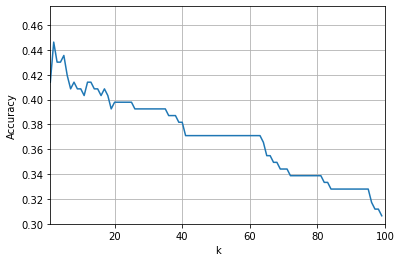

Max accuracy:  0.446236559139785  with k =  2


In [14]:
# Plot an histogram of the accuracy
plt.plot(range(1, kmax), accuracy)

plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xlim(1, kmax)
plt.ylim(0.3, 0.475)
plt.grid()
plt.show()

maxAccuracy = max(accuracy)
kForMaxAccuracy = accuracy.index(maxAccuracy) + 1

print("Max accuracy: ", maxAccuracy, " with k = ", kForMaxAccuracy)

**Task 3 (1 point)** Is k-NN better than Mahalanobis distance ? Make an hypothesis for the reasons.

**Answer:** In this case k-NN achieves worse results than Mahalanobis distance. This might be due to the fact that Mahalanobis distance takes into account the distribution of the data in the space while k-NN method we used does not. This might be a problem since the data is not uniformly distributed in the space.

**Task 4 (1 point)** Do you think we can suggest the approach presented in this exercise to compute TUMOR/STROMA ratio automatically ? Justify your thoughs. If not, suggest at least two ideas to improve it.

*Note:* Annotating all the training dataset is not an option.

**Answer:** In this case we cannot use the followed approcah to compute TUMOR/STROMA ration automatically. This is due to the fact that we have lots of false negative. <br>
Some improvements of this approach might be:
- Instead of computing the average between the distance of all k-nearest points we might consider to compute the average between the distance of all k-nearest points of the same class of the considered element. This might improve the classification of the elements near the separation line of the two classes.
- We could use a different metric for the k-NN method. We could analyze the results using euclidean distance, cosine similarity, Manhattan distance and Minowski distance and choose the one that gives the best results.

---

## Part 2 (12 points)
In this part, we aim to classify cervical cells resulting from Pap smear tests. To that end we'll be using a publicly available cell dataset: Sipakmed (https://www.cs.uoi.gr/~marina/sipakmed.html). The dataset is composed of 4049 images of isolated cells cropped from 966 cluster cell images of Pap smear slides. Each cell in the dataset has been categorized in either of the following categories: 

    - Superficial-Intermediate.
    - Parabasal.
    - Koilocytotic.
    - Dysketarotic.
    - Metaplastic.
Your objective is to implement a classifier to automate the cell classification process. To ease your work we provide you with pre-computed embeddings for each images (`lab-03-data/part2/sipakmed_clean_embeddings.pth`). The embeddings are obtained from a pre-trained ResNet-50 (https://arxiv.org/pdf/1512.03385.pdf) and the corresponding images are also provided (`lab-03-data/part2/sipakmed_clean`). Note that you are free to discard the provided embeddings and work directy with the images.

### 2.1 Dataset (4 points)
Your first task is prepare the dataset such that it can be used to train your model. For that purpose we prepared the skeleton of the class `Sipakmed` that inherits from the class `Dataset` of PyTorch. Read the documentation (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) and complete the missing parts.

In [42]:
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch import nn
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [43]:
# Load the features
features_path = '../data/lab-03-data/part2/sipakmed_clean_embeddings.pth'
data_directory = '../data/lab-03-data/part2'

In [44]:
class Sipakmed(Dataset):
    phase_dict = {
            'train': {'start': 0.0, 'stop': 0.5},
            'val': {'start': 0.5, 'stop': 0.75},
            'test': {'start': 0.75, 'stop': 1.0}
    }
    label_dict = {
        'im_Superficial-Intermediate': 0,
        'im_Parabasal': 1, 
        'im_Metaplastic': 2,
        'im_Koilocytotic': 3,
        'im_Dyskeratotic': 4
    }
    
    def __init__(self, features_path, phase):

        super(Sipakmed, self).__init__()
        # Store class attributes
        self.phase = phase
        
        # Collect the dataimport torch
        import torch.nn.functional as F
        import numpy as np
        self.raw_data = torch.load(features_path)
        self.features, self.labels, self.paths = self.collect_data()
        
    def collect_data(self):
        # Iterate over the dirs/classes
        features, labels, paths = [], [], []
        for dir_name, dir_dict in self.raw_data.items():
            # Get the paths and embeddings
            dir_paths, dir_embeddings = list(zip(*[(k, v) for k, v in dir_dict.items()]))
            
            # Split
            n = len(dir_paths)
            np.random.seed(42)
            permutations = np.random.permutation(n)
            dir_paths = np.array(dir_paths)[permutations]
            dir_embeddings = torch.stack(dir_embeddings)[permutations]
            n_start = int(n * self.phase_dict[self.phase]['start'])
            n_stop = int(n * self.phase_dict[self.phase]['stop'])
            dir_embeddings = dir_embeddings[n_start: n_stop]
            dir_paths = dir_paths[n_start: n_stop]
    
            # Store
            features.append(dir_embeddings)
            paths.append(dir_paths)
            dir_labels = torch.tensor([self.label_dict[p.split('/')[-2]] for p in dir_paths])
            labels.append(dir_labels)
            
        # Merge
        features = torch.cat(features)
        labels = torch.cat(labels)
        paths = np.concatenate(paths)
        return features, labels, paths
            
        
    def __len__(self,):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.labels)
    
    def __getitem__(self, index):
        """
        Returns the embedding, label, and image path of queried index.
        """
        return self.features[index], self.labels[index], data_directory + '/' + self.paths[index]

Once the implementation of `Sipakmed` completed, create 3 instances of the class (train/val/test) with the corresponding `phase` flag.

In [45]:
# Instantiate the datasets
train_dataset = Sipakmed(features_path, phase='train')
val_dataset = Sipakmed(features_path, phase='val')
test_dataset = Sipakmed(features_path, phase='test')

Now that your datasets are ready, use the class `DataLoader` from PyTorch to let it handle efficiently the batching, shuffling, etc. of your data.

In [46]:
# Instantiate the data loaders
torch.manual_seed(42)
train_loader = DataLoader(train_dataset, shuffle=True) # Shuffle the data
val_loader = DataLoader(val_dataset)
test_loader = DataLoader(test_dataset)

Get to know your data. Plot a few example images for each class of your dataset.

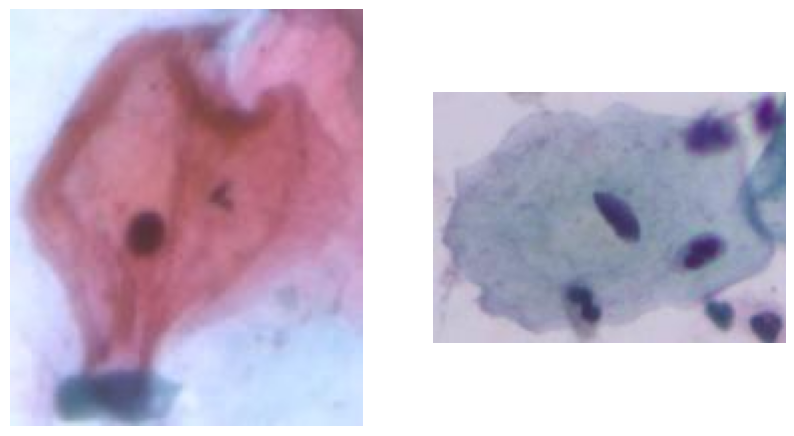

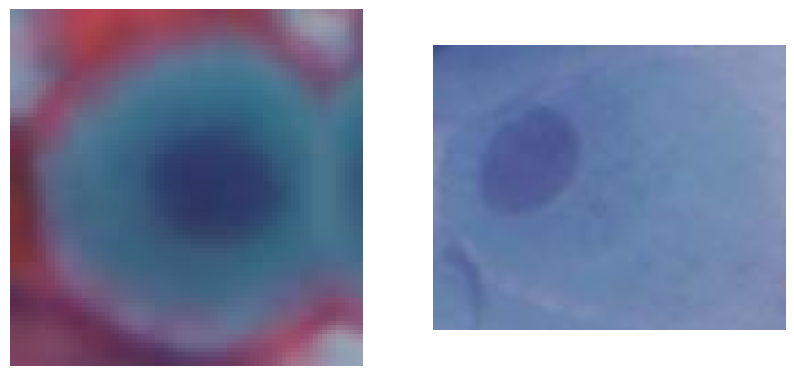

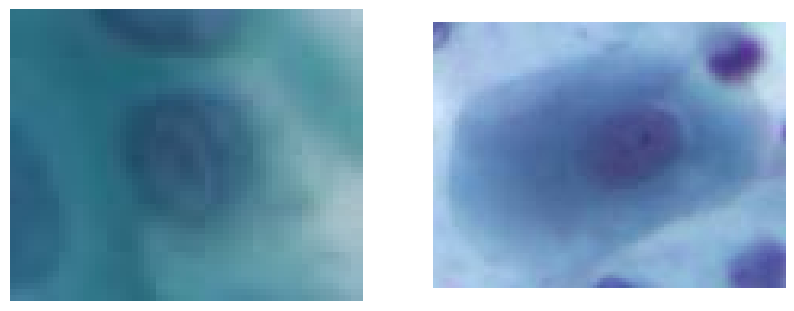

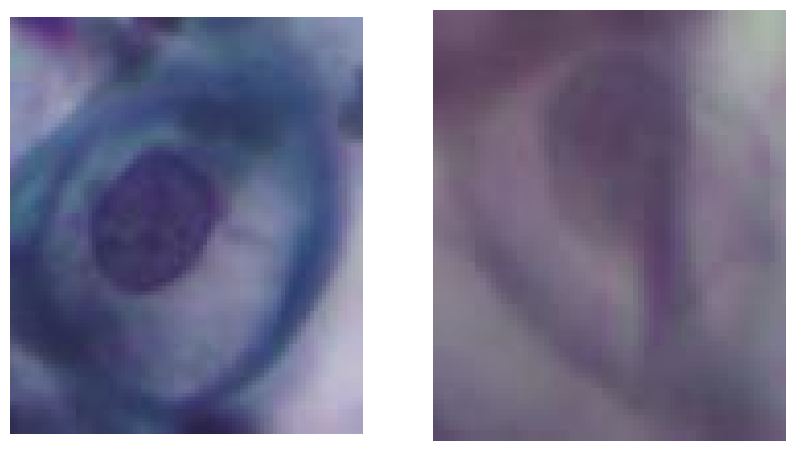

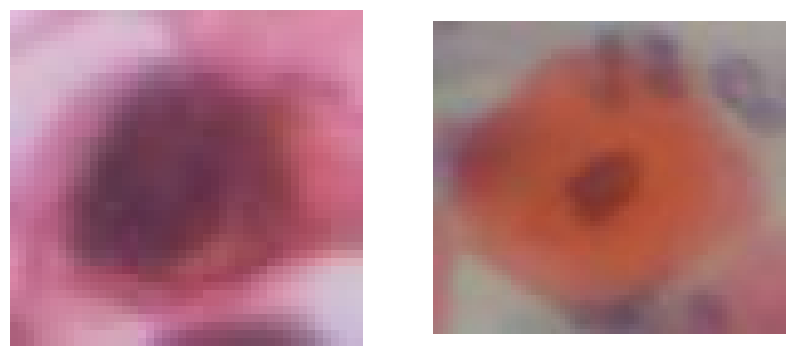

In [47]:
imagesDividedByClasses = [[] for i in range(5)]
for i in range(len(train_dataset)):
    imagesDividedByClasses[train_dataset[i][1]].append(train_dataset[i][2])

# Plot the images
for j in range(5):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    for i in range(2):
        axs[i].imshow(Image.open(imagesDividedByClasses[j][i+6]))
        axs[i].axis('off')
    plt.show()

### 2.2 Training (4 points)
In this part your objective is to implement the required tools to train your model. The first thing you'll need is a a model which takes as input the pre-computed features and returns the corresponding class probabilities/logits.

In [48]:
layer_dims = [64, 16, 5]
lr = 1e-3 * 0.5

from torch import nn

# Implement the model
embedding_dim = train_dataset.features.shape[1]
model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(embedding_dim, layer_dims[0])),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(layer_dims[0], layer_dims[1])),
    ('relu2', nn.ReLU()),
    ('fc3', nn.Linear(layer_dims[1], layer_dims[2])),
    ('output', nn.LogSoftmax(dim=1))
]))

**Comments**:
We chose to use a simple Neural Network composed of two fully connected layers with ReLU activation function and a final layer with SoftMax which acts as a classifier. After finetuing the hyperparameters, we found the best values for the layer dimensions were 64, 16 and 5. The last layer has 5 neurons since we have 5 classes. The optimal learning rate was 0.0005.

The optimizer will keep track of your model's parameters, gradients, etc (https://pytorch.org/docs/stable/optim.html). It is responsible to update your model's parameters after each forward pass using the backpropagation algorithm.

In [49]:
# Set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [50]:
# Set the loss
criterion = nn.CrossEntropyLoss()

Implement a function that takes as input the model's output and the corresponding labels and returns the perçentage of correct predictions.

In [51]:
def accuracy(outputs, labels):
    """
    Computes the accuracy of predictions based on the model outputs (NxK: N samples, K classes) 
    and the labels (N: N samples).
    """
    # outputs shape (N, K)
    # labels shape (N)
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Implement a funtion `train` that forwards the complete training set through your model (= 1 epoch) and updates its parameters after each forward pass. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [52]:
def train(model, optimizer, criterion, loader):
    ''' Trains the model for one epoch'''
    # Set the model in train mode
    model.train()
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    losses = []
    for batch in tqdm(loader):
        # Get the embeddings, labels and paths 
        x, y, path = batch
        
        # Feed the embeddings to the model
        pred = model(x)

        # Compute cross entropy loss
        loss = criterion(pred, y)
        
        # Reset the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()

        # Update the parameters (weights)
        optimizer.step()
        
        # Store the outputs, labels and loss
        full_outputs.append(pred)
        full_labels.append(y)
        losses.append(loss)
        
    
    # Transform the outputs and labels from list of tensors to single tensors
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    
    # Compute the accuracy
    acc = accuracy(full_outputs, full_labels)

    return acc, full_outputs, full_labels, losses

Implement a funtion `validate` that forwards the complete validation or test set through your model and evaluates its predictions. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [53]:
@torch.no_grad()
def validate(model, criterion, loader):
    ''' Validates the model for one epoch'''
    # Set the model in train mode
    model.eval()
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    full_paths = []
    losses = []
    for batch in tqdm(loader):
        # Get the embeddings, labels and paths
        x, y, path = batch
        
        # Feed the embeddings to the model
        pred = model(x)

        # Compute cross entropy loss
        loss = criterion(pred, y)
        
        # Store the outputs, labels and loss
        full_outputs.append(pred)
        full_labels.append(y)
        full_paths.append(path)
        losses.append(loss)
    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    full_paths = np.concatenate(full_paths)
    
    # Compute the accuracy
    acc = accuracy(full_outputs, full_labels)
    
    return acc, full_outputs, full_labels, losses, full_paths

You should now be able to train you model. Alternate between training and validation steps to find and save the best model (best accuracy on the validation set).

In [54]:
# Main loop
epochs = 1
best_acc = 0
model_savepath = '../data/model.pth'

for epoch in range(epochs):
    ''' Trains and evaluates the model'''''
    # Train
    train_acc, train_outputs, train_labels, train_loss = train(model, optimizer, criterion, train_loader)

    # Evaluate
    val_acc, val_outputs, val_labels, val_loss, val_paths = validate(model, criterion, val_loader)
    
    # Save the model
    if val_acc > best_acc:
        best_acc = val_acc
        print('Saving model with accuracy {:.2f}%'.format(best_acc*100))
        torch.save(model.state_dict(), model_savepath)

100%|██████████| 1012/1012 [00:00<00:00, 7936.33it/s]


Saving model with accuracy 90.81%


### 2.3 Evaluation (4 points)
Re-load the best model and evaluate its predictions on the test set.

In [55]:
# Re-load the best model
model.load_state_dict(torch.load(model_savepath))

# Evaluate
test_acc, test_outputs, test_labels, test_loss, test_paths = validate(model, criterion, test_loader)
print('Test accuracy: {:.2f}%'.format(test_acc*100))

100%|██████████| 1015/1015 [00:00<00:00, 7689.47it/s]

Test accuracy: 91.33%


A useful tool to analyze your model's performance on the different classes is the confusion matrix (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Computes its entries for your model and the test set.

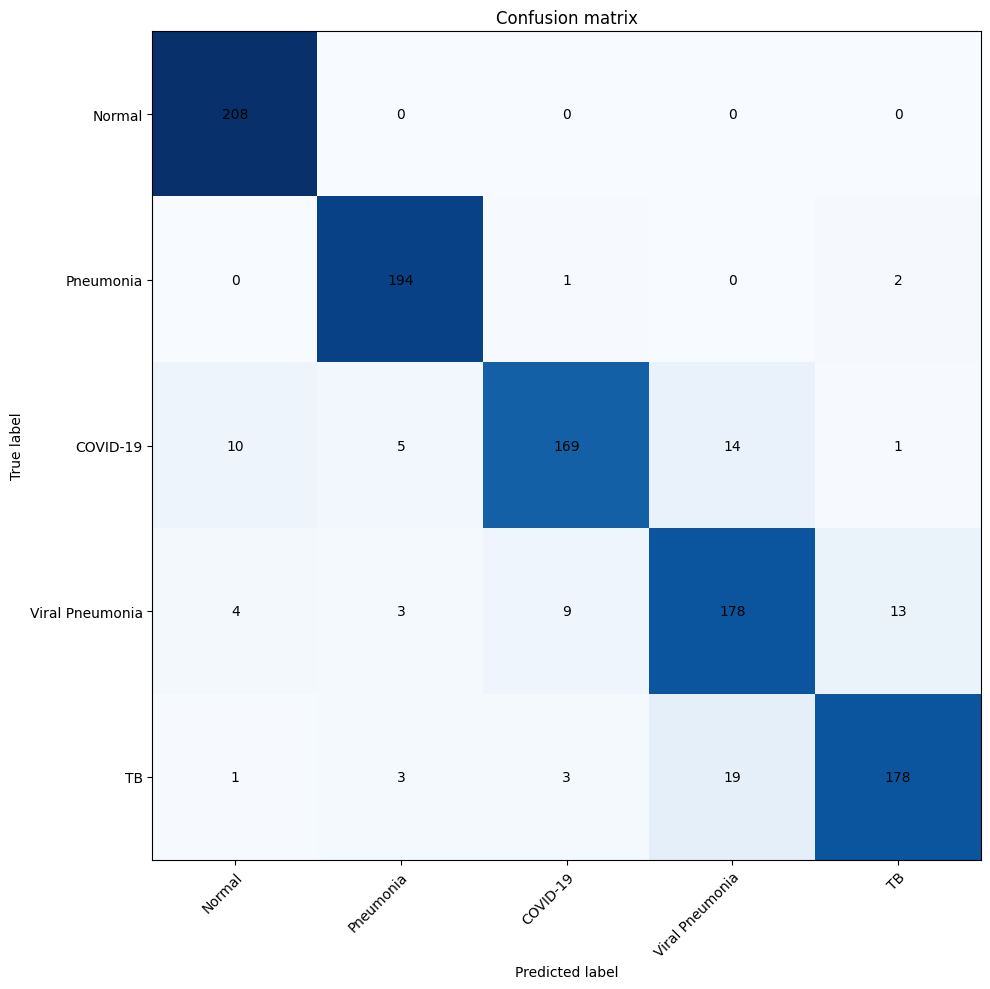

In [56]:
from sklearn.metrics import confusion_matrix
# Display the confusion matrix
cm = confusion_matrix(test_labels, torch.argmax(test_outputs, dim=1))
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cm, cmap=plt.cm.Blues)
ax.set_xticks(np.arange(5))
ax.set_yticks(np.arange(5))
ax.set_xticklabels(['Normal', 'Pneumonia', 'COVID-19', 'Viral Pneumonia', 'TB'])
ax.set_yticklabels(['Normal', 'Pneumonia', 'COVID-19', 'Viral Pneumonia', 'TB'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(5):
    for j in range(5):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
ax.set_title("Confusion matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
fig.tight_layout()
plt.show()

Alternatively it can be useful to plot the problematic samples as well as the predicted and ground truth classes. Can you do so?

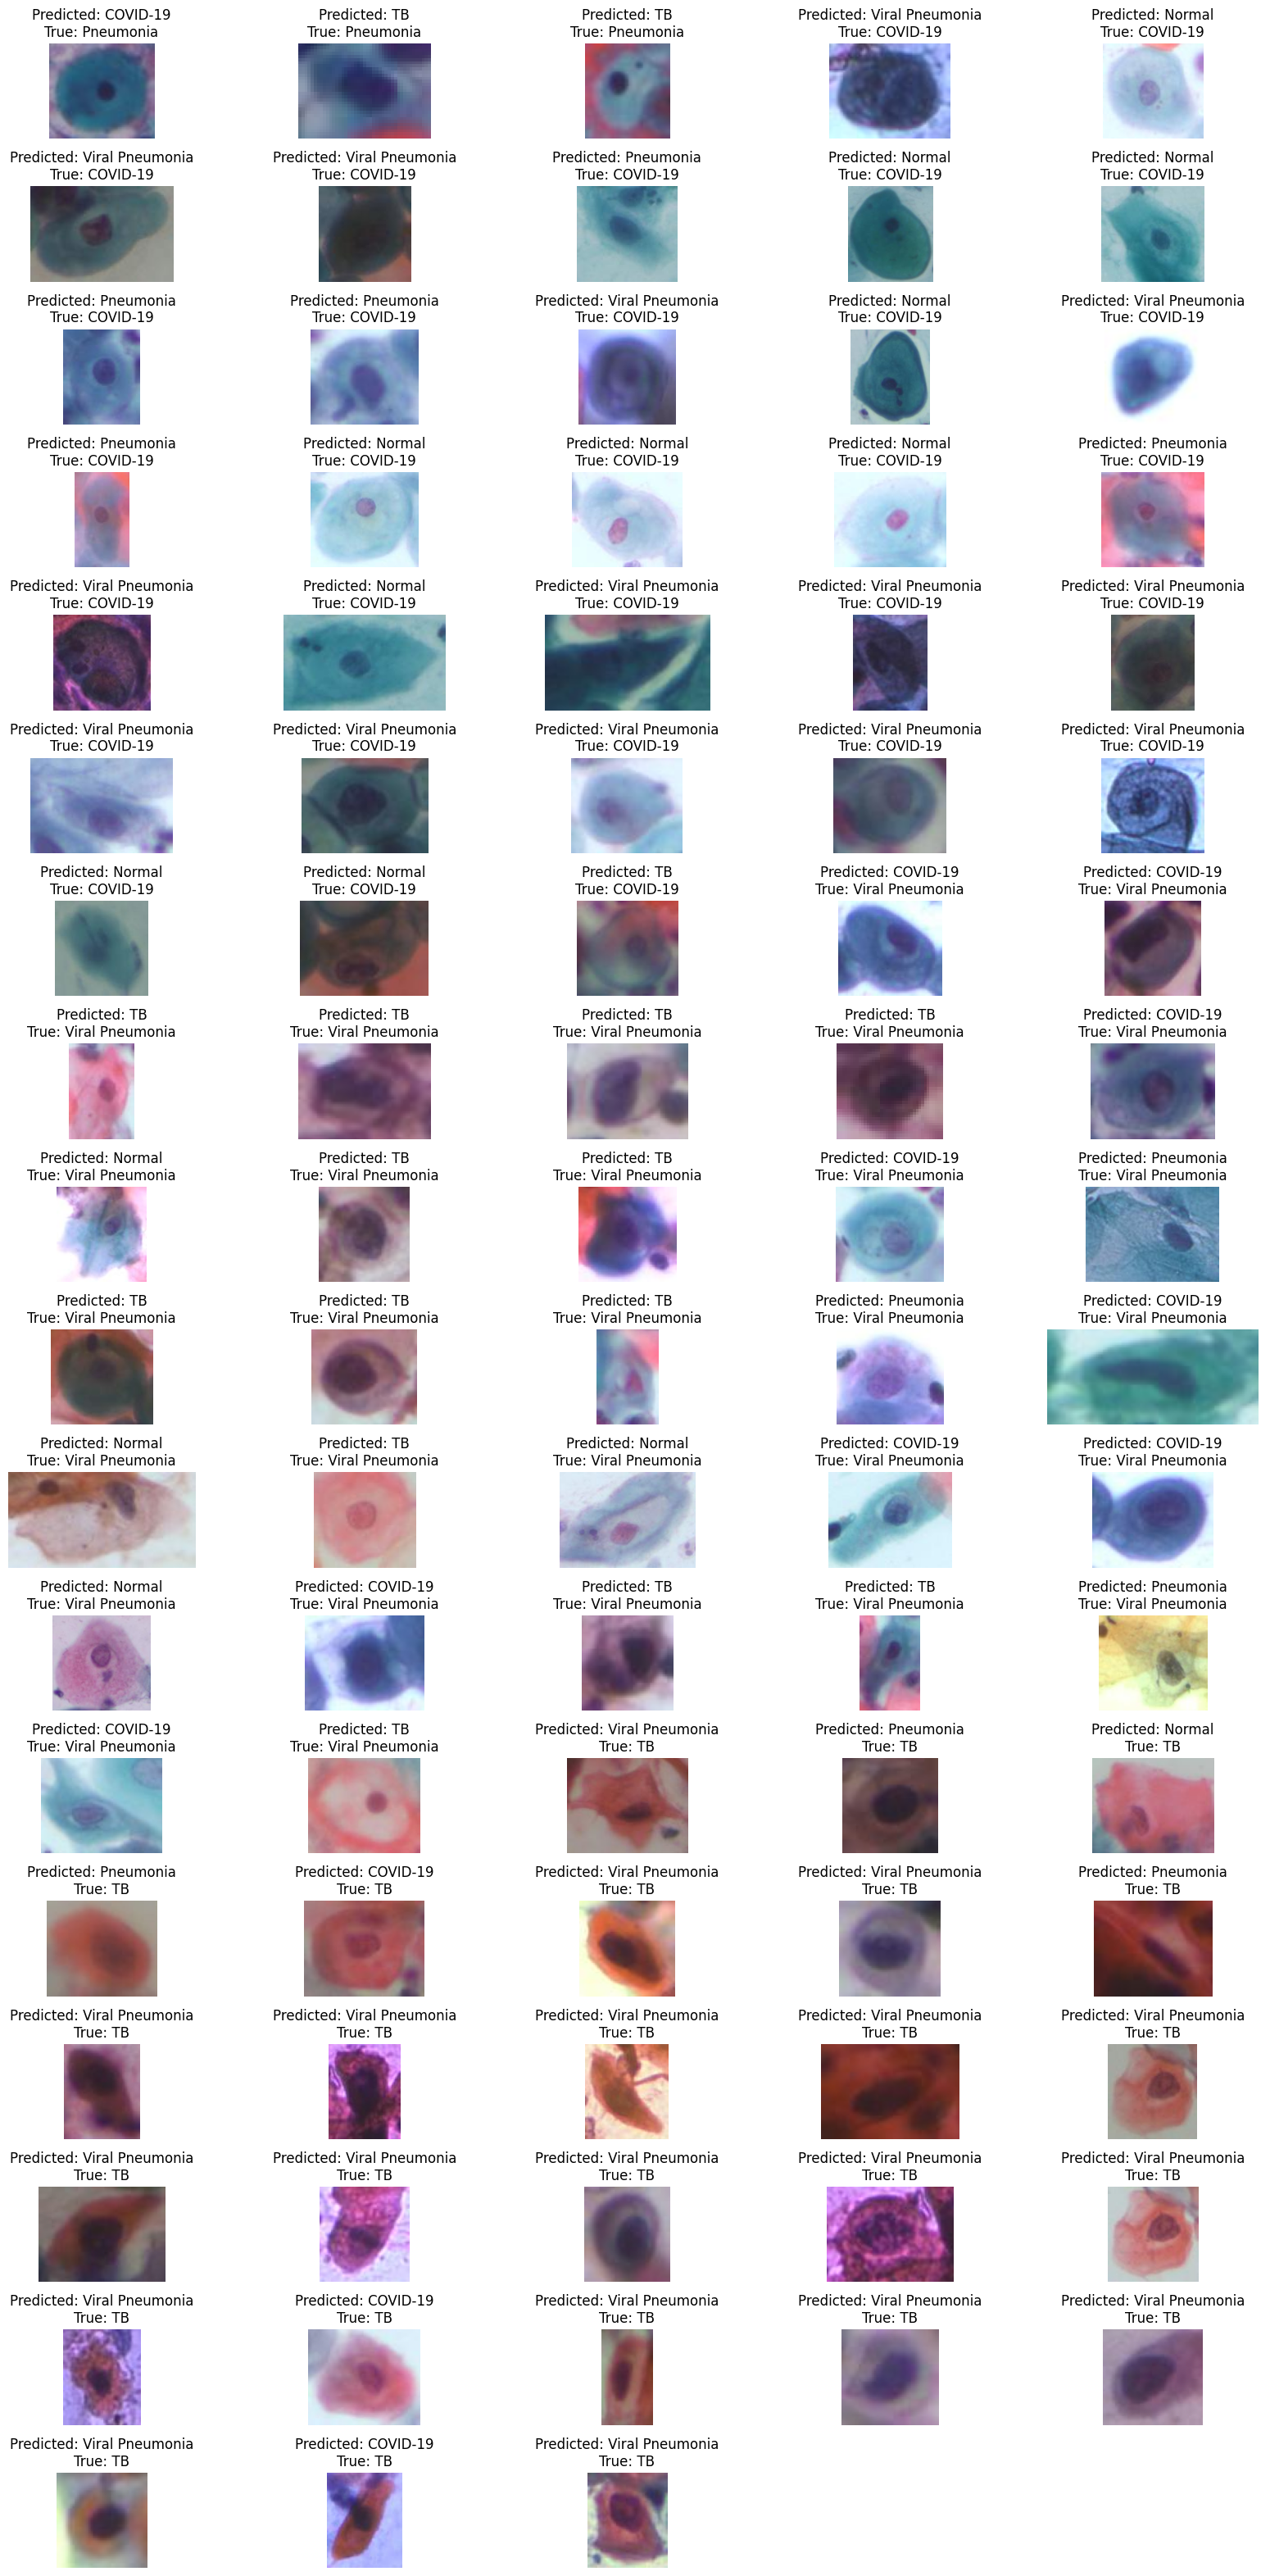

In [57]:
# Find the misclassified samples
misclassified = np.where(test_labels != torch.argmax(test_outputs, dim=1))[0]
classes = ['Normal', 'Pneumonia', 'COVID-19', 'Viral Pneumonia', 'TB']
# Plot the misclassified samples
num_missclassified = len(misclassified)
num_rows = num_missclassified//5+1
num_cols = 5
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 40))
for row in range(num_rows):
    for col in range(num_cols):
        i = row*num_cols+col
        if i < num_missclassified:
            axs[row, col].imshow(Image.open(test_paths[misclassified[i]]))
            fig.subplots_adjust(hspace=0.5)
            axs[row, col].set_title(f'Predicted: {classes[torch.argmax(test_outputs, dim=1)[misclassified[i]]]}\nTrue: {classes[test_labels[misclassified[i]]]}')
            axs[row, col].axis('off')
        else:
            axs[row, col].axis('off')
plt.show()